In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import os
import torch
import torch.nn as nn
from collections import OrderedDict
from layers import *

import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import matplotlib.pyplot as plt
import numpy as np
import os, cv2, math
import torch
from torch.utils.data import Dataset, DataLoader
from networks import WormAgeModel, WormRegModel, WormSegModel
import torch.nn as nn

from dataset import Dataset4Celeganser
#from training import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
%load_ext autoreload
%autoreload 2

## path of data.tsv
## path paremeters
dataDir = './data'
scale = [0,1,2,3]

#model parameters
#
batch_size = 4
cropped_size = [960, 960]
sets = ['visual','val']
device ='cpu'
if torch.cuda.is_available(): device='cuda:0' # cpu or cuda
    

# dataset for visualization
datasetv = {"visual": Dataset4Celeganser(data_dir = dataDir,size = cropped_size, sets = "visual", sizeOri=[2160,2560],
                                        downsampleFactor=1, downsampleFactorOri=1,scale=scale),
            "val": Dataset4Celeganser(data_dir = dataDir,size = cropped_size, sets = "val",
                                      downsampleFactor=1,scale=scale)}


dataloaders = {set_name: DataLoader(datasetv[set_name], 
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', num_workers = 1)
               for set_name in sets}


visual image  		size 8
visual GT 		size 8
val image  		size 8
val GT 		size 8


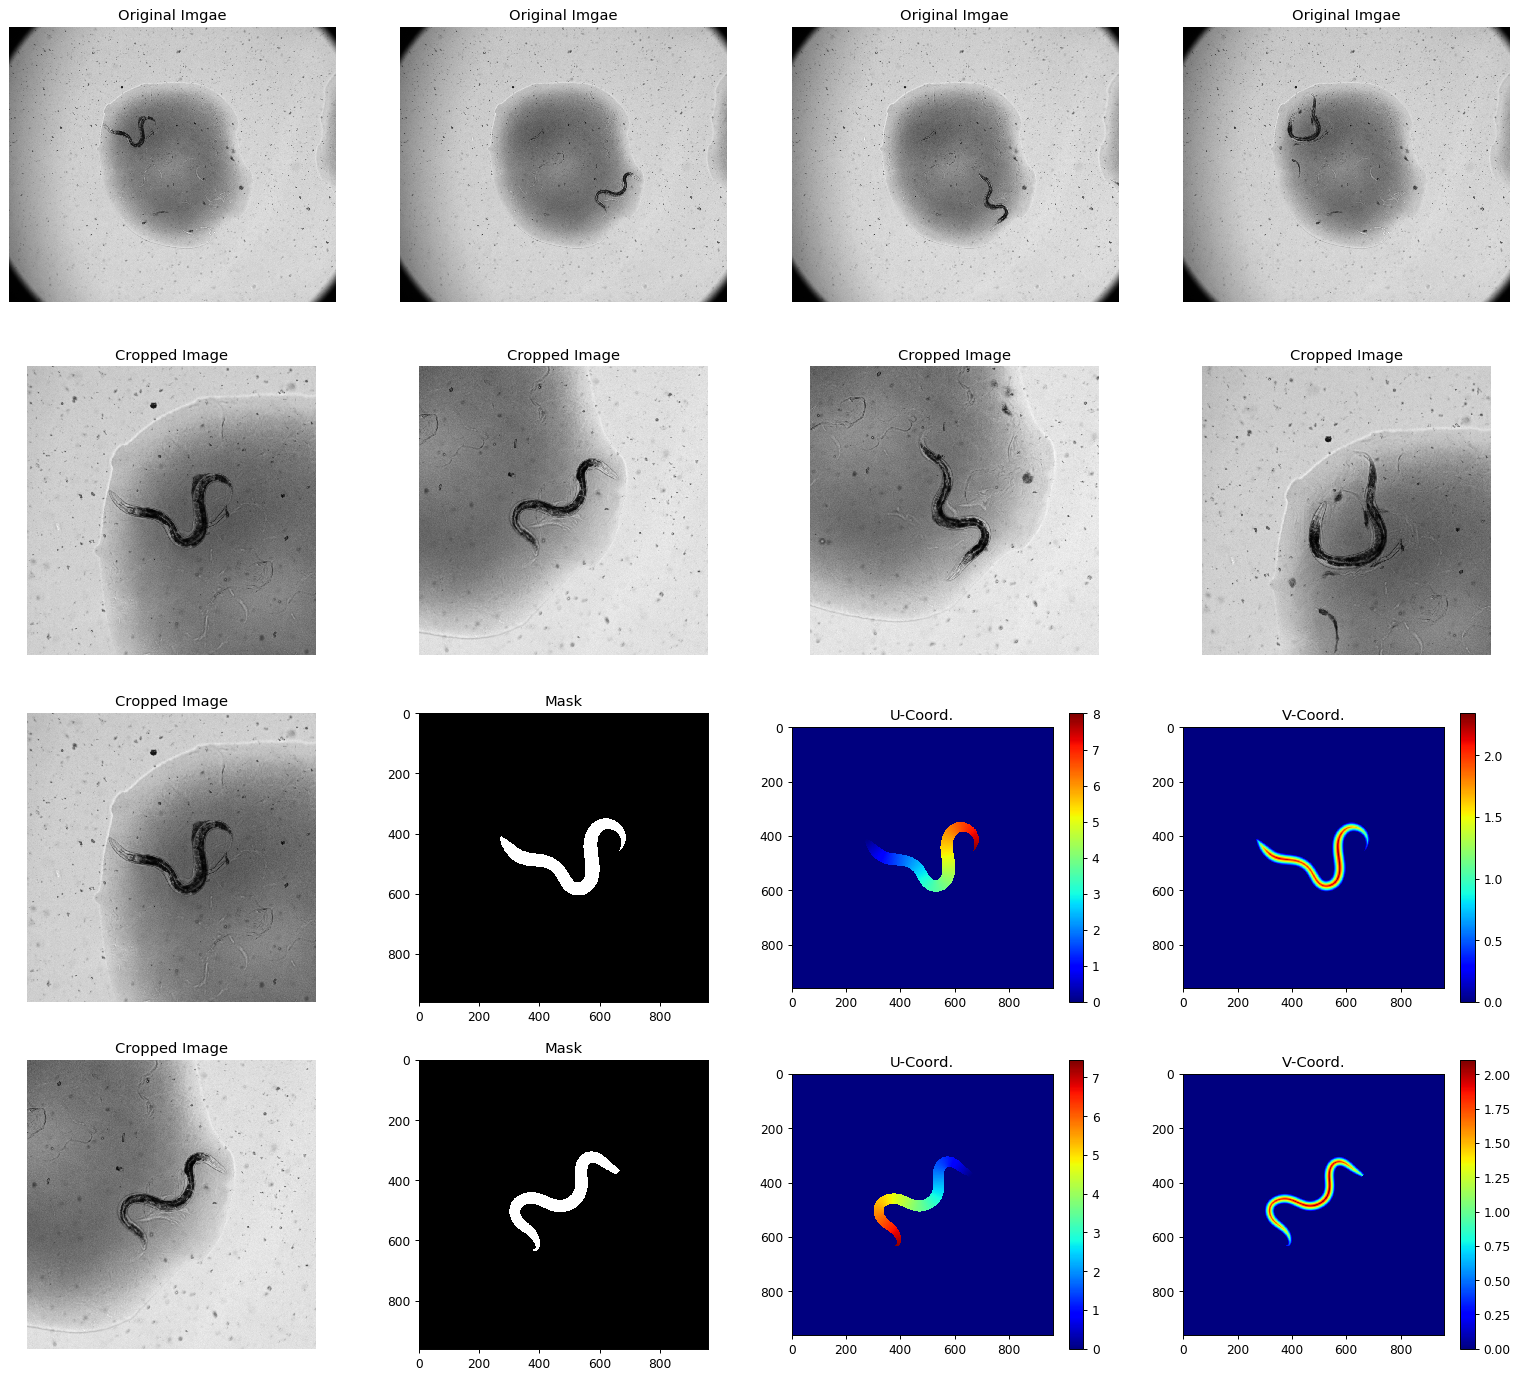

In [3]:
sampler = iter(dataloaders['visual'])
sample = sampler.next()
imgList, masks, xcoords, ycoords, rycoords, extend_ori, age, straight = sample

figWinNumHeight, figWinNumWidth, subwinCount = 4, 4, 1
plt.figure(figsize=(22,20), dpi=88, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()

for sampleIndex in range(4):
    # visualize image
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    image = extend_ori[sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))      
    plt.imshow(image[0], cmap='gray')    
    plt.axis('off')
    plt.title('Original Imgae')


for sampleIndex in range(4):
    # visualize image
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    image = imgList[sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))      
    plt.imshow(image[0], cmap='gray')    
    plt.axis('off')
    plt.title('Cropped Image')

    
for sampleIndex in range(2):
    # visualize image
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    image = imgList[sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))      
    plt.imshow(image[0], cmap='gray')    
    plt.axis('off')
    plt.title('Cropped Image')
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    mask = masks[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(mask[0], cmap='gray')
    plt.axis('on')
    plt.title('Mask')
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    xcoord = xcoords[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(xcoord[0], cmap='jet')
    plt.axis('on')
    plt.colorbar()
    plt.title('U-Coord.')

    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    ycoord = rycoords[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    
    plt.imshow(ycoord[0], cmap='jet')
    plt.axis('on')
    plt.colorbar()
    plt.title('V-Coord.')


In [17]:

segModel = WormSegModel(34, scale, pretrained=False)
segModel.load_state_dict(torch.load("./modules/coarse-seg.paramOnly",map_location='cpu'))
segModel.eval();

regModele = WormRegModel(34, scale, pretrained=False)
regModele.load_state_dict(torch.load("./modules/e2e-reg.paramOnly",map_location='cpu'))
regModele.eval();

regModelc = WormRegModel(34, scale, pretrained=False)
regModelc.load_state_dict(torch.load("./modules/c2e-reg.paramOnly",map_location='cpu'))
regModelc.eval();

ageModel = WormAgeModel(34, scale, pretrained=False)
ageModel.load_state_dict(torch.load("./modules/age.paramOnly",map_location='cpu'))
ageModel.eval();


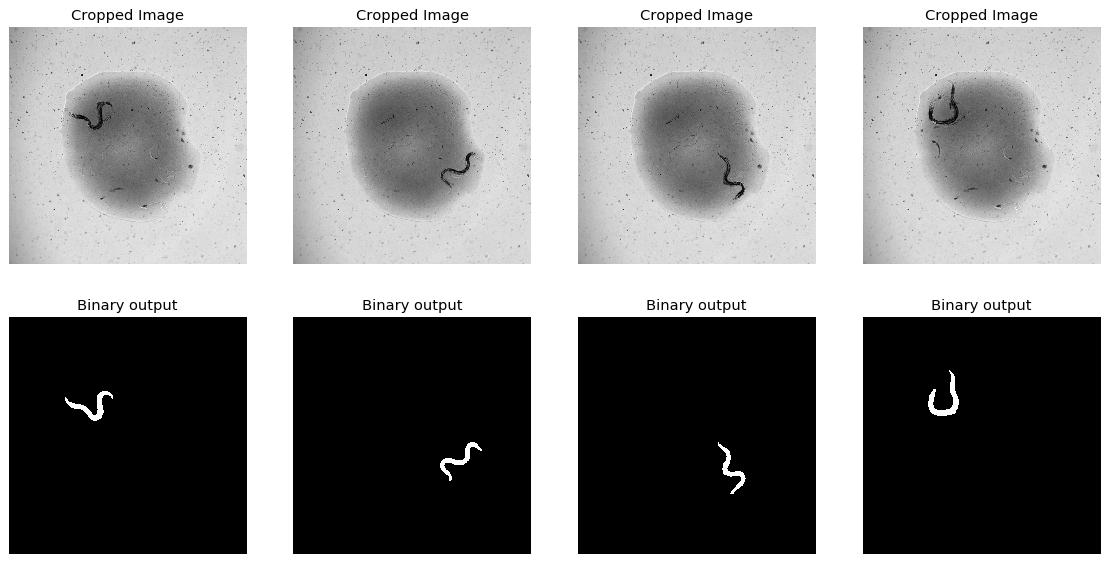

In [18]:
sampler = iter(dataloaders['val'])
sample = sampler.next()
imgList, masks, xcoords, ycoords, rycoords, extend_ori, age, straight = sample
seg_res = segModel(extend_ori)

figWinNumHeight, figWinNumWidth, subwinCount = 2, 4, 1
plt.figure(figsize=(16,8), dpi=88, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()

for sampleIndex in range(4):    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    image = extend_ori[sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))      
    plt.imshow(image[0], cmap='gray')    
    plt.axis('off')
    plt.title('Cropped Image')
    #plt.colorbar()
    
for sampleIndex in range(4):    
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    res = seg_res[('disp', 0)].cpu().detach().numpy()[sampleIndex]  
    bi_mask = (res>0.5).astype(np.float)*255
    plt.imshow(bi_mask[0], cmap='gray')  
    plt.axis('off')
    plt.title('Binary output')

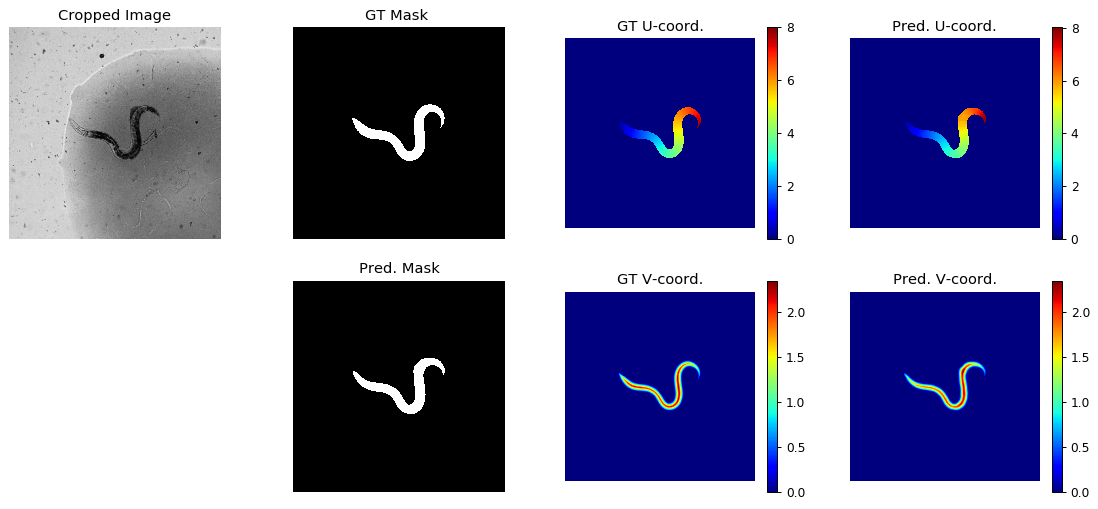

In [19]:
sampler = iter(dataloaders['val'])
sample = sampler.next()
imgList, masks, xcoords, ycoords, rycoords, extend_ori, age, straight = sample
out = regModelc(imgList)

figWinNumHeight, figWinNumWidth, subwinCount = 2, 4, 1
plt.figure(figsize=(16,7), dpi=88, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
for sampleIndex in range(1):    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    resm = (out[('Mask', 0)].cpu().detach().numpy()[sampleIndex] >0.5).astype(np.float32) *1
    subwinCount += 1
    image = imgList[sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))      
    plt.imshow(image[0], cmap='gray')    
    plt.axis('off')
    plt.title('Cropped Image')
    #plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    mask = masks[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(mask[0], cmap='gray')
    plt.axis('off')
    plt.title('GT Mask ')
    #plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    xcod = xcoords[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(xcod[0], cmap='jet')
    plt.axis('off')
    plt.title('GT U-coord.')
    plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    resx = out[('X_Coord', 0)].cpu().detach().numpy()[sampleIndex] * resm
    plt.imshow(resx[0], cmap='jet')  
    plt.axis('off')
    plt.title('Pred. U-coord.')
    #plt.clim(0,3)
    plt.colorbar()
    
    subwinCount += 1
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    
    plt.imshow(resm[0], cmap='gray')  
    plt.title('Pred. Mask')
    plt.axis('off')
    #plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    
    ycod = rycoords[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(ycod[0], cmap='jet')
    plt.axis('off')
    plt.title('GT V-coord.')
    plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    resy = out[('Y_Coord', 0)].cpu().detach().numpy()[sampleIndex] * resm
    plt.imshow(resy[0], cmap='jet')  
    plt.axis('off')
    plt.colorbar()
    #plt.clim(0,3)
    plt.title('Pred. V-coord.')
   

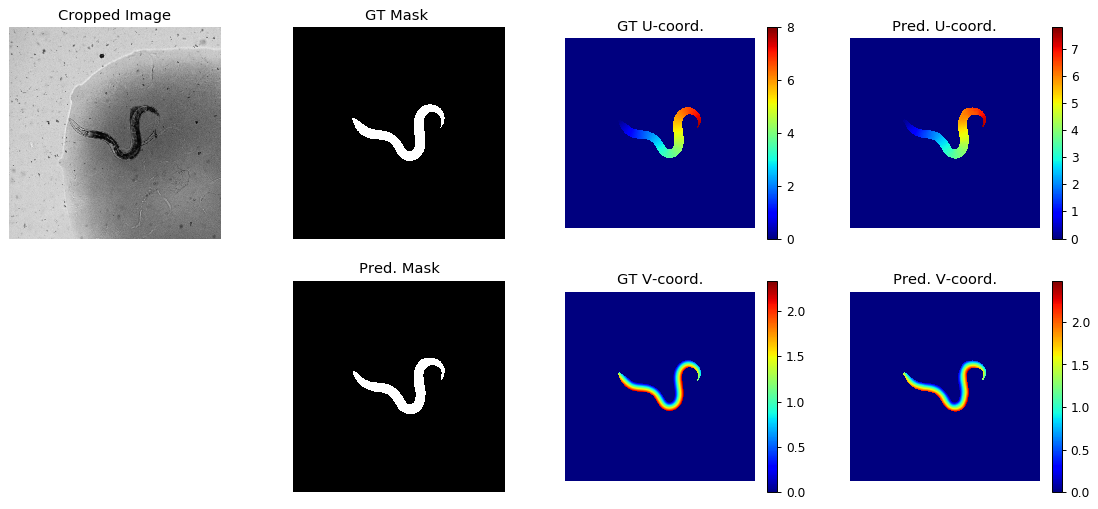

In [20]:
sampler = iter(dataloaders['val'])
sample = sampler.next()
imgList, masks, xcoords, ycoords, rycoords, extend_ori, age, straight = sample
out = regModele(imgList)

figWinNumHeight, figWinNumWidth, subwinCount = 2, 4, 1
plt.figure(figsize=(16,7), dpi=88, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
for sampleIndex in range(1):    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    resm = (out[('Mask', 0)].cpu().detach().numpy()[sampleIndex] >0.5).astype(np.float32) *1
    subwinCount += 1
    image = imgList[sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))      
    plt.imshow(image[0], cmap='gray')    
    plt.axis('off')
    plt.title('Cropped Image')
    #plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    mask = masks[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(mask[0], cmap='gray')
    plt.axis('off')
    plt.title('GT Mask ')
    #plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    xcod = xcoords[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(xcod[0], cmap='jet')
    plt.axis('off')
    plt.title('GT U-coord.')
    plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    resx = out[('X_Coord', 0)].cpu().detach().numpy()[sampleIndex] * resm
    plt.imshow(resx[0], cmap='jet')  
    plt.axis('off')
    plt.title('Pred. U-coord.')
    #plt.clim(0,3)
    plt.colorbar()
    
    subwinCount += 1
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    
    plt.imshow(resm[0], cmap='gray')  
    plt.title('Pred. Mask')
    plt.axis('off')
    #plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    
    ycod = ycoords[0][sampleIndex].cpu().numpy()#.squeeze().transpose((1,2,0))
    plt.imshow(ycod[0], cmap='jet')
    plt.axis('off')
    plt.title('GT V-coord.')
    plt.colorbar()
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    resy = out[('Y_Coord', 0)].cpu().detach().numpy()[sampleIndex] * resm
    plt.imshow(resy[0], cmap='jet')  
    plt.axis('off')
    plt.colorbar()
    #plt.clim(0,3)
    plt.title('Pred. V-coord.')
   